In [3]:
import copy
import json
import numbers
import os
import os.path as osp
from json import JSONDecodeError
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.interpolate
import seaborn as sns

# Step 1: Processing training results

In [10]:
# 目录名 -> 环境正式名称
env_mapping = {
    'inter': 'Intersection',
    'round': 'Roundabout',
}

In [11]:
def parse_trials_in_dir(root):
    """
    Read and form data into a dataframe
    root:
        trial_0/
            progress.csv
        ...
    """
    print(f'Processing env <{osp.split(root)[-1]}>...')
    df = []
    # 获得root下的所有为目录的路径
    paths = [osp.join(root, p) for p in os.listdir(root) if osp.isdir(osp.join(root, p))]
    for pi, p in enumerate(tqdm(paths)):
        # print(f"Finish {pi + 1}/{len(paths)} trials.")
        try:
            ret = pd.read_csv(osp.join(p, 'progress.csv')) # <~~ Modified Here!
            # 加入文件名称，便于后续区分
            ret['file_name'] = osp.split(p)[-1]

        except (FileNotFoundError, JSONDecodeError):
            print("Path {} not found. Continue.".format(p))
            continue
        if ret is not None:
            df.append(ret)
    if not df:
        print("No Data Found!")
        return None
    df = pd.concat(df)

    return df


def parse_one_algo(path):
    """
    path: 
        inter/
        round/
    """
    df = []
    env_paths = [osp.join(path, p) for p in os.listdir(path) if osp.isdir(osp.join(path, p))]
    for p in env_paths:
        _df = parse_trials_in_dir(p)
        # 加入环境/场景名称
        env_name = env_mapping[osp.split(p)[-1]]
        _df['env'] = env_name
        df.append(_df)

    df = pd.concat(df)
    return df

In [3]:
def smooth(data, num_points=200, interpolate_x="timesteps_total", interpolate_y=None, y_span=1, splitter="file_name"):
    data = data.copy()
    if num_points <= 0:
        return data
    trial_list = [j for i, j in data.groupby(splitter)] # i: file_name values, j: df
    num_points_ = int(max(len(df) for df in trial_list))
    print("Found {} points, draw {} points.".format(num_points_, num_points))
    num_points = min(num_points, num_points_)
    range_min = min(df[interpolate_x].min() for df in trial_list) # 1024
    range_max = max(df[interpolate_x].max() for df in trial_list) # 2000896
    interpolate_range = np.linspace(range_min, range_max, num_points)
    keys = data.keys() # columns
    new_trial_list = []
    for df in trial_list:
        mask = np.logical_and(df[interpolate_x].min() < interpolate_range, interpolate_range < df[interpolate_x].max())
        mask_rang = interpolate_range[mask]
        if len(df) > 1:
            new_df = {}
            df = df.reset_index(drop=True)
            for k in keys:
                if isinstance(df[k][0], numbers.Number):
                    try:
                        new_df[k] = scipy.interpolate.interp1d(df[interpolate_x], df[k])(mask_rang)
                    except ValueError:
                        continue
                elif isinstance(df[k][0], list):
                    continue
                else:
                    new_df[k] = df[k].unique()[0]
            new_trial_list.append(pd.DataFrame(new_df))
        else:
            new_trial_list.append(df)
    return pd.concat(new_trial_list, ignore_index=True)


处理原始训练`progress.csv`然后分别保存中间结果:

### IPPO

In [12]:
algo_path = 'eval_checkpoints/ippo'
algo_name = 'IPPO'
new_path = 'progress_ippo'

df = parse_one_algo(algo_path)
new_df = smooth(df)
new_df["algo"] = algo_name
new_df.to_csv("{}.csv".format(new_path))
# del df
# del new_df
print("Finished ", algo_name)

Processing env <inter>...


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 14.03it/s]


Processing env <round>...


100%|██████████| 8/8 [00:00<00:00, 14.36it/s]


Found 1954 points, draw 200 points.
Finished  IPPO


### CCPPO Concat

In [14]:
algo_path = 'eval_checkpoints/ccppo-concat'
algo_name = 'MAPPO'
new_path = 'progress_mappo'

df = parse_one_algo(algo_path)
new_df = smooth(df)
new_df["algo"] = algo_name
new_df.to_csv("{}.csv".format(new_path))
# del df
# del new_df
print("Finished", algo_name)

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 13.59it/s]


Processing env <round>...


100%|██████████| 8/8 [00:00<00:00, 14.35it/s]


Found 1954 points, draw 200 points.
Finished MAPPO


### CCPPO MF

In [13]:
algo_path = 'eval_checkpoints/ccppo-mf'
algo_name = 'MFPO'
new_path = 'progress_mfpo'

df = parse_one_algo(algo_path)
new_df = smooth(df)
new_df["algo"] = algo_name
new_df.to_csv("{}.csv".format(new_path))
print("Finished", algo_name)

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 14.07it/s]


Processing env <round>...


100%|██████████| 8/8 [00:00<00:00, 14.51it/s]


Found 1954 points, draw 200 points.
Finished MFPO


### CoPO

In [15]:
algo_path = 'eval_checkpoints/copo'
algo_name = 'CoPO'
new_path = 'progress_copo'

df = parse_one_algo(algo_path)
new_df = smooth(df)
new_df["algo"] = algo_name
new_df.to_csv("{}.csv".format(new_path))
print("Finished", algo_name)

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 12.29it/s]


Processing env <round>...


100%|██████████| 8/8 [00:00<00:00, 13.35it/s]


Found 1954 points, draw 200 points.
Finished CoPO


### SCPO

In [16]:
algo_path = 'eval_checkpoints/scpo'
algo_name = 'SCPO'
new_path = 'progress_scpo'

df = parse_one_algo(algo_path)
new_df = smooth(df)
new_df["algo"] = algo_name
new_df.to_csv("{}.csv".format(new_path))
print("Finished", algo_name)

Processing env <inter>...


100%|██████████| 8/8 [00:00<00:00, 13.56it/s]


Processing env <round>...


100%|██████████| 8/8 [00:00<00:00, 13.63it/s]


Found 1954 points, draw 200 points.
Finished SCPO


In [17]:
new_df.columns

Index(['episode_reward_max', 'episode_reward_min', 'episode_reward_mean',
       'episode_len_mean', 'episodes_this_iter', 'num_faulty_episodes',
       'num_healthy_workers', 'num_in_flight_async_reqs',
       'num_remote_worker_restarts', 'num_agent_steps_sampled',
       'num_agent_steps_trained', 'num_env_steps_sampled',
       'num_env_steps_trained', 'num_env_steps_sampled_this_iter',
       'num_env_steps_trained_this_iter',
       'num_env_steps_sampled_throughput_per_sec',
       'num_env_steps_trained_throughput_per_sec', 'timesteps_total',
       'num_steps_trained_this_iter', 'agent_timesteps_total', 'done',
       'episodes_total', 'training_iteration', 'trial_id', 'date', 'timestamp',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'SuccessRate',
       'CrashRate', 'OutRate', 'MaxStepRate', 'RewardMean', 'StepMean',
       'DistanceMean', 'NeighboursMean', 'RewardsTotal', 'AgentsTotal',
   

# Step 2: Aggregate all results

分别读取中间结果，`concat`在一起并保存成一个`training_results.csv`文件

In [36]:
all_algo_names = ['ippo', 'mfpo', 'mappo', 'copo', 'scpo']
all_results = pd.concat([pd.read_csv(f'progress_{name}.csv') for name in all_algo_names]).reset_index()

In [30]:
all_results.env.unique()

array(['Intersection', 'Roundabout'], dtype=object)

/Users/jimmy/miniforge3/envs/marl/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


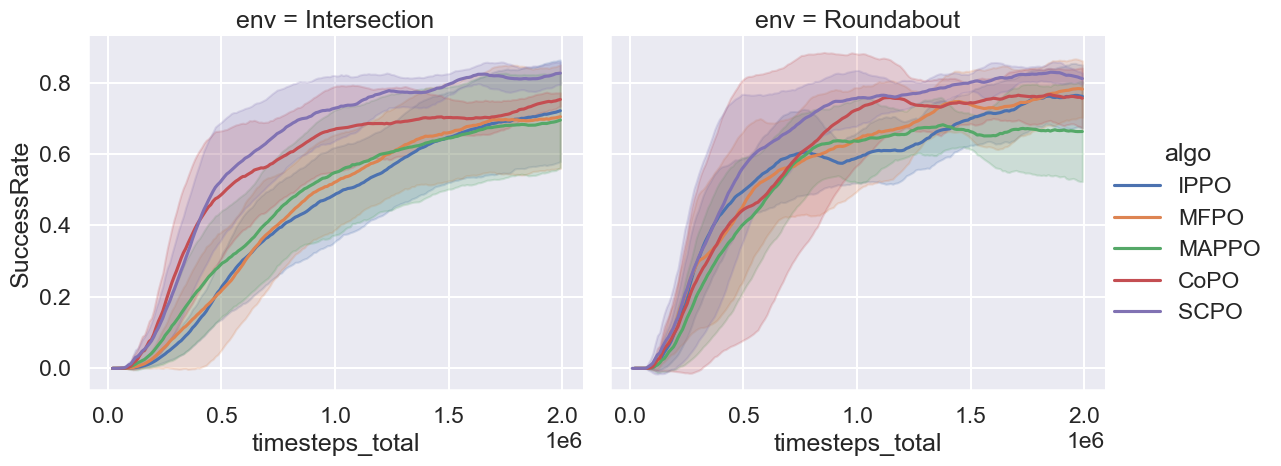

In [38]:
# Draw a little figure to see if data is processed properly.
sns.set("talk", "darkgrid")
ax = sns.relplot(
    x="timesteps_total",
    y="SuccessRate", 
    hue='algo',
    data=all_results.copy(),
    # ci="sd",
    errorbar='sd',
    kind="line",
    col="env",
    aspect=1.15,
)

In [39]:
all_results.to_csv('progress_all.csv')

# Step 3: Plot

In [4]:
data = pd.read_csv("progress_all.csv")

In [5]:
data.algo.unique()

array(['IPPO', 'MFPO', 'MAPPO', 'CoPO', 'SCPO'], dtype=object)

/Users/jimmy/miniforge3/envs/marl/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


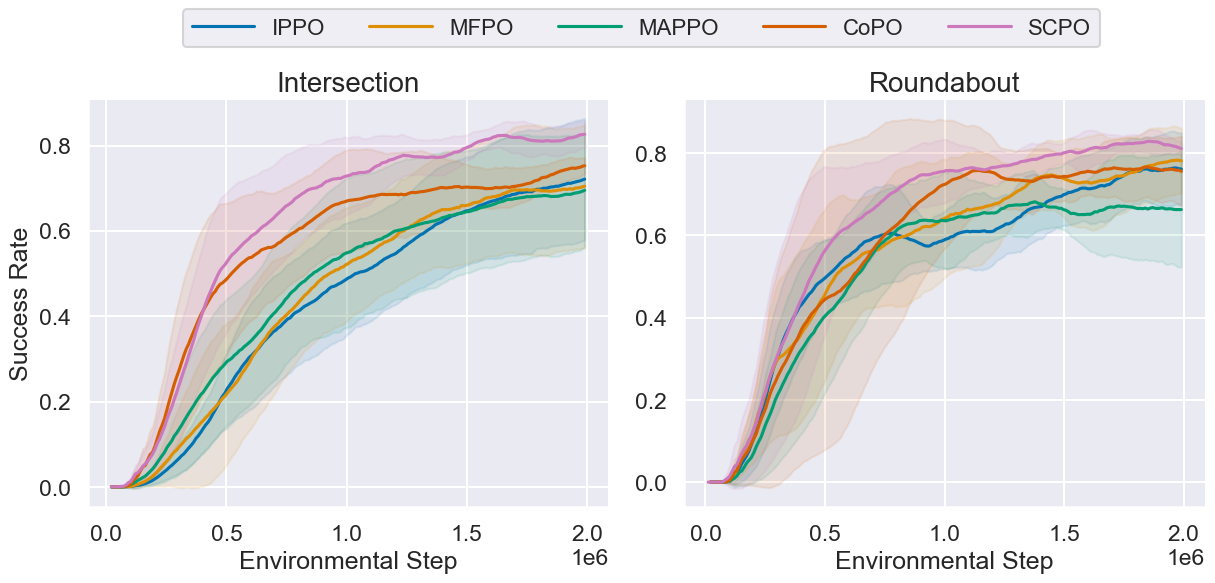

In [8]:
plot_df = data.copy()
x = "timesteps_total"
y = "SuccessRate"
y_label = 'Success Rate'

tmplist = []
for algo in ['IPPO', 'MFPO', 'MAPPO', 'CoPO', 'SCPO']:
    tmp = plot_df[plot_df.algo == algo]
#     tmp = tmp[tmp.timesteps_total < 100_0000]
    tmplist.append(tmp)
plot_df = pd.concat(tmplist)

c = sns.color_palette("colorblind")
sns.set("talk", "darkgrid")

ax = sns.relplot(
    x=x,
    y=y, 
    hue='algo',
#     palette=[c[0], c[2]],
    palette=list(c)[:len(plot_df.algo.unique())],
    data=plot_df,
    # ci="sd", # deprecated
    errorbar='sd',
#     legend=None,
    kind="line",
    col="env",
    facet_kws=dict(sharey=False, sharex=False),
#     linewidth=1,
#     height=5,
#     aspect=1.333,
#     facet_kws={"alpha": 0.1}
#     col_wrap=3,
    err_kws=dict(alpha=0.1),
    aspect=1.25,
#     linewidth=2,
#     legend=None
#     legend_out=False
#     facet_kws={"alpha": 0.2}
)

for axxx in ax.axes.flat:
    axxx.set_xlabel("Environmental Step")
ax.set_ylabels(y_label)

fontsize = 20
ax.set_titles(col_template = '{col_name}', size=fontsize)
for env, axxx in ax.axes_dict.items():
    axxx.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

hs = ax.legend.legend_handles
ax.legend.set_visible(False)

# legend_ax = ax.fig.add_axes([1., 0.9, 0.1, 0.1])
plt.legend(
    handles=hs, 
    # title="Method", 
    # title_fontsize=fontsize, 
    loc='best',
    bbox_to_anchor=(0.82, 1.25), 
    frameon=True,
    ncol=5,
    fontsize=fontsize*0.8,
    labelspacing=0.8, 
    handlelength=2.8
)

plt.subplots_adjust(top=1)

plt.savefig('learning_curve.pdf', format='pdf', dpi=300, facecolor='#FFF', bbox_inches="tight")
plt.savefig('learning_curve.png', format='png', dpi=200, facecolor='#FFF', bbox_inches="tight")